<a href="https://colab.research.google.com/github/hasiburrahman1/NLP/blob/master/MedQuAD_3_GHR_QA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
import xml.etree.ElementTree as et 
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


####Convert XML into DataFrame


In [2]:
xtree = et.parse("/content/drive/My Drive/Colab Notebooks/MedQuAD_3_GHR_QA/joined.xml")
xroot = xtree.getroot()
lst = xroot.findall('QAPairs/QAPair')
data1 = []
data2 = []
data3 = []
print(len(lst))
print(lst)
print("\n")

for item in lst:
    for x in item:
         if x.get('qtype') != None:
            qtype = x.get('qtype')
            data1.append(qtype)
    Question = item.find('Question').text
    data2.append(Question)
    Answer = item.find('Answer').text
    data3.append(Answer)

5430
[<Element 'QAPair' at 0x7f29f18c0d18>, <Element 'QAPair' at 0x7f29f18c0e08>, <Element 'QAPair' at 0x7f29f18c0ef8>, <Element 'QAPair' at 0x7f29f18cb048>, <Element 'QAPair' at 0x7f29f18cb138>, <Element 'QAPair' at 0x7f29f18cb5e8>, <Element 'QAPair' at 0x7f29f18cb6d8>, <Element 'QAPair' at 0x7f29f18cb7c8>, <Element 'QAPair' at 0x7f29f18cb8b8>, <Element 'QAPair' at 0x7f29f18cb9a8>, <Element 'QAPair' at 0x7f29f18cd1d8>, <Element 'QAPair' at 0x7f29f18cd2c8>, <Element 'QAPair' at 0x7f29f18cd3b8>, <Element 'QAPair' at 0x7f29f18cd4a8>, <Element 'QAPair' at 0x7f29f18cd598>, <Element 'QAPair' at 0x7f29f18cda48>, <Element 'QAPair' at 0x7f29f18cdb88>, <Element 'QAPair' at 0x7f29f18cdc78>, <Element 'QAPair' at 0x7f29f18cdd68>, <Element 'QAPair' at 0x7f29f18cdea8>, <Element 'QAPair' at 0x7f29f18d94f8>, <Element 'QAPair' at 0x7f29f18d95e8>, <Element 'QAPair' at 0x7f29f18d96d8>, <Element 'QAPair' at 0x7f29f18d97c8>, <Element 'QAPair' at 0x7f29f18d98b8>, <Element 'QAPair' at 0x7f29f18d9d68>, <Eleme

In [3]:
df = pd.DataFrame(list(zip(data1, data2, data3)), 
               columns =['qtype', 'Question', 'Answer']) 

df.drop(df.columns[[2]], axis = 1, inplace = True)
print(len(df)) 
df

5430


,qtype,Question
0,information,What is (are) Aarskog-Scott syndrome ?
1,frequency,How many people are affected by Aarskog-Scott ...
2,genetic changes,What are the genetic changes related to Aarsko...
3,inheritance,Is Aarskog-Scott syndrome inherited ?
4,treatment,What are the treatments for Aarskog-Scott synd...
...,...,...
5425,information,What is (are) 9q22.3 microdeletion ?
5426,frequency,How many people are affected by 9q22.3 microde...
5427,genetic changes,What are the genetic changes related to 9q22.3...
5428,inheritance,Is 9q22.3 microdeletion inherited ?


###Basic data cleaning

In [4]:
df["qtype"].value_counts()

inheritance        1086
frequency          1086
genetic changes    1086
treatment          1086
information        1086
Name: qtype, dtype: int64

In [0]:
## categorical to numerical
encode = {
    "genetic changes" : 0,
    "inheritance"  : 1,       
    "frequency" : 2,    
    "information" : 3,     
    "treatment"  : 4,    
}

In [6]:
df["qtype"] = df["qtype"].apply(lambda x: encode[x])
df.head()

,qtype,Question
0,3,What is (are) Aarskog-Scott syndrome ?
1,2,How many people are affected by Aarskog-Scott ...
2,0,What are the genetic changes related to Aarsko...
3,1,Is Aarskog-Scott syndrome inherited ?
4,4,What are the treatments for Aarskog-Scott synd...


###Data cleaning for NLP

In [7]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [9]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(df):
    ques_lines = list()
    lines = df["Question"].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        
        ques_lines.append(words)
        
    return ques_lines

ques_lines = CleanTokenize(df)
print("total line are ", len(ques_lines)) 
ques_lines[0:10]

total line are  5430


[['aarskogscott', 'syndrome'],
 ['many', 'people', 'affected', 'aarskogscott', 'syndrome'],
 ['genetic', 'changes', 'related', 'aarskogscott', 'syndrome'],
 ['aarskogscott', 'syndrome', 'inherited'],
 ['treatments', 'aarskogscott', 'syndrome'],
 ['abdominal', 'wall', 'defect'],
 ['many', 'people', 'affected', 'abdominal', 'wall', 'defect'],
 ['genetic', 'changes', 'related', 'abdominal', 'wall', 'defect'],
 ['abdominal', 'wall', 'defect', 'inherited'],
 ['treatments', 'abdominal', 'wall', 'defect']]

In [10]:
len(max(ques_lines, key=len))

13

###Train-test split

In [11]:
validation_split = 0.2
max_length = 15


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(ques_lines)
sequences = tokenizer_obj.texts_to_sequences(ques_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

ques_lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
qtype =  df['qtype'].values

indices = np.arange(ques_lines_pad.shape[0])
np.random.shuffle(indices)
ques_lines_pad = ques_lines_pad[indices]
qtype = qtype[indices]

n_values = np.max(qtype) + 1

Y = np.eye(n_values)[qtype]


num_validation_samples = int(validation_split * ques_lines_pad.shape[0])

X_train_pad = ques_lines_pad[:-num_validation_samples]
y_train = Y[:-num_validation_samples]
X_test_pad = ques_lines_pad[-num_validation_samples:]
y_test = Y[-num_validation_samples:]

unique tokens -  1419
vocab size - 1420


In [12]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (4344, 15)
Shape of y_train: (4344, 5)
Shape of X_test_pad: (1086, 15)
Shape of y_test: (1086, 5)


###Custom word2vec model

In [13]:
import gensim
model = gensim.models.Word2Vec(sentences=ques_lines, size=100, window=5, workers=4, min_count=1, sg=1) #sg= 1:skip-gram 0:cbow
vocab_words = list(model.wv.vocab)   

print(len(vocab_words))
print(vocab_words)

1419
['aarskogscott', 'syndrome', 'many', 'people', 'affected', 'genetic', 'changes', 'related', 'inherited', 'treatments', 'abdominal', 'wall', 'defect', 'abetalipoproteinemia', 'acatalasemia', 'aceruloplasminemia', 'achondrogenesis', 'achondroplasia', 'achromatopsia', 'acral', 'peeling', 'skin', 'acromicric', 'dysplasia', 'actinaccumulation', 'myopathy', 'activated', 'acute', 'promyelocytic', 'leukemia', 'adamsoliver', 'dyskinesia', 'adenine', 'phosphoribosyltransferase', 'deficiency', 'adenosine', 'deaminase', 'monophosphate', 'adenylosuccinate', 'lyase', 'adermatoglyphia', 'adiposis', 'dolorosa', 'adolescent', 'idiopathic', 'scoliosis', 'adult', 'polyglucosan', 'body', 'disease', 'adultonset', 'leukoencephalopathy', 'axonal', 'spheroids', 'pigmented', 'glia', 'african', 'iron', 'overload', 'agerelated', 'macular', 'degeneration', 'aicardi', 'aicardigoutieres', 'alagille', 'alexander', 'disorder', 'glycosylation', 'alkaptonuria', 'allanherndondudley', 'allergic', 'asthma', 'alpershu

In [14]:
filename = "questype_word2vec_full.txt"
model.wv.save_word2vec_format(filename, binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
embedding_index = {}
f = open(os.path.join('', '/content/questype_word2vec_full.txt'),  encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coeff = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coeff
f.close()

In [0]:
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

####Create LSTM model

In [18]:
# define model
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(units=32,  dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 100)           142000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 159,189
Trainable params: 17,189
Non-trainable params: 142,000
_________________________________________________________________
None



###Model Training

In [19]:
history = model.fit(X_train_pad, y_train, epochs=10,batch_size=32, validation_data=(X_test_pad, y_test), verbose=1)

Train on 4344 samples, validate on 1086 samples
Epoch 1/10
4344/4344 [==============================] - 6s 1ms/step - loss: 1.4902 - accuracy: 0.3354 - val_loss: 1.1847 - val_accuracy: 0.5773
Epoch 2/10
4344/4344 [==============================] - 4s 986us/step - loss: 0.9676 - accuracy: 0.6103 - val_loss: 0.6394 - val_accuracy: 0.7145
Epoch 3/10
4344/4344 [==============================] - 4s 1ms/step - loss: 0.7258 - accuracy: 0.6740 - val_loss: 0.5431 - val_accuracy: 0.7311
Epoch 4/10
4344/4344 [==============================] - 4s 987us/step - loss: 0.6357 - accuracy: 0.7162 - val_loss: 0.5167 - val_accuracy: 0.7302
Epoch 5/10
4344/4344 [==============================] - 4s 978us/step - loss: 0.5883 - accuracy: 0.7366 - val_loss: 0.5022 - val_accuracy: 0.7873
Epoch 6/10
4344/4344 [==============================] - 4s 1ms/step - loss: 0.5544 - accuracy: 0.7438 - val_loss: 0.4676 - val_accuracy: 0.8140
Epoch 7/10
4344/4344 [==============================] - 4s 992us/step - loss: 0.51

In [23]:
print(history.history['loss'])
print(history.history['accuracy'])
print(history.history['val_loss'])
print(history.history['val_accuracy'])

[1.490241994954385, 0.9676390417592521, 0.7258056203524271, 0.6356908207001168, 0.5882682462204007, 0.5543553191434393, 0.5192972849745777, 0.4850378310921882, 0.4276002151531409, 0.4040695089661614]
[0.33540517, 0.61026704, 0.67403316, 0.71616024, 0.73664826, 0.74378455, 0.7674954, 0.7971915, 0.8303407, 0.84254146]
[1.1847332070545598, 0.6393788915751828, 0.5430716153776228, 0.5166858091648552, 0.5021890304145672, 0.4676422166670664, 0.37653486883442705, 0.3252827357192066, 0.26620149110232927, 0.24147876924243422]
[0.5773480534553528, 0.7145488262176514, 0.7311233878135681, 0.7302025556564331, 0.7872928380966187, 0.8139963150024414, 0.8941068053245544, 0.8987108469009399, 0.9023941159248352, 0.9226519465446472]


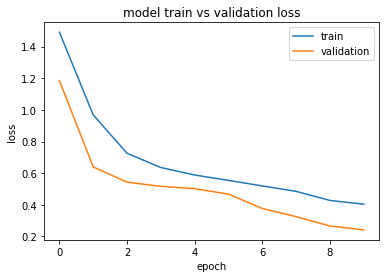

In [25]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()


####Can this model detect qtype?



In [0]:
from pandas import *
import operator
def predict_(s):
    x_final = pd.DataFrame({"Question":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    #print(f'NumPy Array:\n{[pred]}')
    pred = pred.ravel()
    listOfInt  = pred.tolist()
    #print(listOfInt)
    listOfStr = ["genetic changes", "inheritance", "frequency" , "information" , "treatment"]
    # Create a zip object from two lists
    zipbObj = zip(listOfStr, listOfInt)
    # Create a dictionary from zip object
    dictOfresult = dict(zipbObj)
    #print(dictOfresult)
    print(s, end =" ")
    print( max(dictOfresult.items(), key=operator.itemgetter(1))[0])

In [139]:
predict_("What is (are) Coronavirous syndrome ?")    

What is (are) Coronavirous syndrome ? information


In [147]:
predict_("How many people are affected by Coronavirous syndrome ?")

How many people are affected by Coronavirous syndrome ? frequency


In [144]:
predict_("Is Coronavirous inherited ?")

Is Coronavirous inherited ? treatment
